In [0]:
%matplotlib inline

In [74]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive



Neural Transfer Using PyTorch
=============================


**Author**: `Alexis Jacq <https://alexis-jacq.github.io>`_
 
**Edited by**: `Winston Herring <https://github.com/winston6>`_

Introduction
------------

This tutorial explains how to implement the `Neural-Style algorithm <https://arxiv.org/abs/1508.06576>`__
developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.
Neural-Style, or Neural-Transfer, allows you to take an image and
reproduce it with a new artistic style. The algorithm takes three images,
an input image, a content-image, and a style-image, and changes the input 
to resemble the content of the content-image and the artistic style of the style-image.

 
.. figure:: /_static/img/neural-style/neuralstyle.png
   :alt: content1



Underlying Principle
--------------------

The principle is simple: we define two distances, one for the content
($D_C$) and one for the style ($D_S$). $D_C$ measures how different the content
is between two images while $D_S$ measures how different the style is
between two images. Then, we take a third image, the input, and
transform it to minimize both its content-distance with the
content-image and its style-distance with the style-image. Now we can
import the necessary packages and begin the neural transfer.

Importing Packages and Selecting a Device
-----------------------------------------
Below is a  list of the packages needed to implement the neural transfer.

-  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
   neural networks with PyTorch)
-  ``torch.optim`` (efficient gradient descents)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
   images)
-  ``torchvision.transforms`` (transform PIL images into tensors)
-  ``torchvision.models`` (train or load pre-trained models)
-  ``copy`` (to deep copy the models; system package)



In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
from resizeimage import resizeimage
import os

Next, we need to choose which device to run the network on and import the
content and style images. Running the neural transfer algorithm on large
images takes longer and will go much faster when running on a GPU. We can
use ``torch.cuda.is_available()`` to detect if there is a GPU available.
Next, we set the ``torch.device`` for use throughout the tutorial. Also the ``.to(device)``
method is used to move tensors or modules to a desired device. 



In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
l=os.listdir('drive/My Drive/GoghNet/data/style_train')
example_nums=[int(x.split('_')[0]) for x in l] # num of examples w/ matching style_train


Loading the Images
------------------

Now we will import the style and content images. The original PIL images have values between 0 and 255, but when
transformed into torch tensors, their values are converted to be between
0 and 1. The images also need to be resized to have the same dimensions.
An important detail to note is that neural networks from the
torch library are trained with tensor values ranging from 0 to 1. If you
try to feed the networks with 0 to 255 tensor images, then the activated
feature maps will be unable sense the intended content and style.
However, pre-trained networks from the Caffe library are trained with 0
to 255 tensor images. 


.. Note::
    Here are links to download the images required to run the tutorial:
    `picasso.jpg <http://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg>`__ and
    `dancing.jpg <http://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg>`__.
    Download these two images and add them to a directory
    with name ``images`` in your current working directory.



In [80]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

data_loc = 'drive/My Drive/GoghNet/data'

def convert_pil(image):
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def load_pair(image_num):
    style_img = Image.open("{}/orig/{:04d}.jpg".format(data_loc, image_num))
    content_img = Image.open("{}/style_train/{:04d}_t.jpg".format(data_loc, image_num))
    
    overlap_size = (min(style_img.size[0], content_img.size[0]), min(style_img.size[1], content_img.size[1]))
    style_img = resizeimage.resize_crop(style_img, overlap_size)
    content_img = resizeimage.resize_crop(content_img, overlap_size)
    return convert_pil(style_img), convert_pil(content_img)

tensors = list(map(load_pair, example_nums))
style_img = [t[0] for t in tensors]
content_img = [t[1] for t in tensors]


torch.Size([1, 3, 128, 154]) torch.Size([1, 3, 128, 154])
torch.Size([1, 3, 128, 148]) torch.Size([1, 3, 128, 148])
torch.Size([1, 3, 128, 192]) torch.Size([1, 3, 128, 192])
torch.Size([1, 3, 128, 192]) torch.Size([1, 3, 128, 192])
torch.Size([1, 3, 169, 128]) torch.Size([1, 3, 169, 128])
torch.Size([1, 3, 128, 228]) torch.Size([1, 3, 128, 228])
torch.Size([1, 3, 167, 128]) torch.Size([1, 3, 167, 128])
torch.Size([1, 3, 128, 167]) torch.Size([1, 1, 128, 167])
torch.Size([1, 3, 188, 128]) torch.Size([1, 3, 188, 128])
torch.Size([1, 3, 163, 128]) torch.Size([1, 3, 163, 128])
torch.Size([1, 3, 156, 128]) torch.Size([1, 3, 156, 128])
torch.Size([1, 3, 128, 227]) torch.Size([1, 3, 128, 227])
torch.Size([1, 3, 128, 180]) torch.Size([1, 3, 128, 180])
torch.Size([1, 3, 128, 228]) torch.Size([1, 3, 128, 228])
torch.Size([1, 3, 128, 192]) torch.Size([1, 3, 128, 192])
torch.Size([1, 3, 128, 250]) torch.Size([1, 3, 128, 250])
torch.Size([1, 3, 128, 196]) torch.Size([1, 3, 128, 196])
torch.Size([1,

304 304


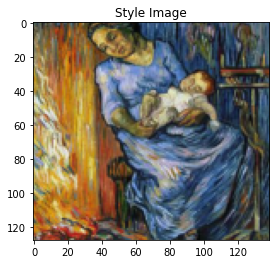

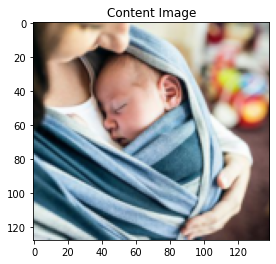

In [35]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [39]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

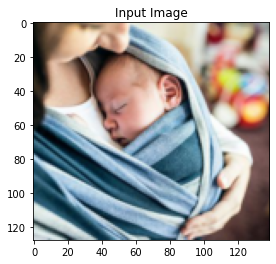

In [42]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.




In [84]:
for i in range(len(style_img)):
  output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img[i], style_img[i], content_img[i])
  image = output.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = unloader(image)
  image.save("{}/fakes/{:04d}_f.jpg".format(data_loc, example_nums[i]))

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Streaming output truncated to the last 5000 lines.
Optimizing..
run [50]:
Style Loss : 136.372116 Content Loss: 19.228405

run [100]:
Style Loss : 47.051479 Content Loss: 18.348484

run [150]:
Style Loss : 25.620226 Content Loss: 17.476330

run [200]:
Style Loss : 14.682434 Content Loss: 16.298267

run [250]:
Style Loss : 8.674021 Content Loss: 15.263539

run [300]:
Style Loss : 5.038560 Content Loss: 14.292486

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 85.629562 Content Loss: 24.740013

run [100]:
Style Loss : 27.687428 Content Loss: 23.338068

run [150]:
Style Loss : 10.913753 Content Loss: 19.935822

run [200]:
Style Loss : 5.649911 Content Loss: 17.153124

run [250]:
Style Loss : 3.801429 Content Loss: 15.360676

run [300]:
Style Loss : 3.027969 Content Loss: 14.256118

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 31.992559 Content Loss: 8.078016

run [100]:
Style Loss : 5.513272 Content Loss: 7.371018

run [150]:
Style Loss 